# Assignment 2 - Eleanor Adachi

Our team's code can be found here: https://github.com/eleanor-adachi/ARE212_Materials

## 1. Exercises (Identifying Assumptions for Regression)

### (2) Suppose $y$, $x$ and $u$ are scalar random variables, with $y$ and $x$ observed but $u$ unobserved. Consider the function $h(x) = x^3$; under standard assumptions this satisfies our concerns about measurability, so $\mathbb{E}(u|x) = 0$ implies $\mathbb{E}(u x^3) = 0$. Use this last condition to motivate a simple least squares estimator of the regression equation $y = \alpha + \beta x + u$. How does this differ from the usual OLS estimator? Why might one prefer one to the other, and under what conditions?

$
y = \alpha + \beta x + u \\
(x^3) y = (x^3) \alpha + (x^3) \beta x + (x^3) u \\
y x^3  - \alpha x^3 - u x^3 =  \beta x^4 \\
(x^{-4}) y x^3  - (x^{-4}) \alpha x^3 - (x^{-4}) u x^3 =  \beta \\
b = \mathbb{E}((x^{-4}) y x^3)  - \mathbb{E}((x^{-4}) \alpha x^3) - \mathbb{E}((x^{-4}) u x^3)
$

Use $\mathbb{E}(u x^3) = 0$

$
\beta = \mathbb{E}((x^{-4}) y x^3)  - \mathbb{E}((x^{-4}) \alpha x^3) \\
\beta = \mathbb{E}(x^{-1} y)  - \alpha \mathbb{E}(x^{-1})
$

Switching to regression world

$
b= \frac{\overline{y} - a}{\overline{x}}
$

The usual OLS estimator is $b = (X^T X)^{-1} X^T Y$ or when $k=1$, $b = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{\sum_{i=1}^{n} (x_i - \overline{x})^2}$

These two estimators lead to equivalent results. However, the estimator $b= \frac{\overline{y} - a}{\overline{x}}$ might be preferred if we have an estimate for $a$ since the computation is simpler. However, if we don't know $a$, then we would prefer the usual OLS estimator since it does not require any information about $a$.

## 2. Wright (1928)

Consider the canonical demand and supply model in which quantity supplied is a function of price and a set of "supply shifters"; quantity demanded is a function of price and set of "demand shifters"; and market clearing implies that at some price quantity demanded is equal to quantity supplied. A linear version of this model is fully specified and solved in [this Jupyter Notebook](https://github.com/ligonteaching/ARE212_Materials/blob/master/wright34.ipynb).

Consider the following questions:

1. (Control) What is the expected demand if we set the price $p = p_0$?

2. (Condition) What is the expected demand if we observe $p = p_0$?

3. (Counterfactual) If prices and quantities are observed to be $(p_0, q_0)$, what would demand be if we were to change the price to $p_1$, ceteris paribus?

Answers could be mathematical expressions, or code that answers the question for the model given in the Jupyter notebook.

### (1) (Control) What is the expected demand if we set the price $p = p_0$?

First, recreate the linear model in [wright34.ipynb](https://github.com/ligonteaching/ARE212_Materials/blob/master/wright34.ipynb) representing:

$$
   q_D = \alpha p + u\qquad q_S = \beta p + v\qquad q_D = q_S,
$$

where $u$ and $v$ have normal distributions of the form:

$F_u(u) = \frac{1}{\sigma \sqrt{2 \pi}} e^{−\frac{(u − \mu)^2}{2\sigma^2}}$

In [212]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# Structural parameters;
(α,β) = (-1,2)     
σ = {'u':1/2,'v':1/3}
μ = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=μ['u'], scale=σ['u'])  # Demand shocks
v = iid.norm(loc=μ['v'], scale=σ['v'])  # Supply shocks

# Reduced form coefficients
π = [[-β/(α - β), -1/(α - β)],
     [ α/(α - β), 1/(α - β)]]

# Generate N realizations of system
# Outcomes Y have columns (q,p)
N = 10

# Arrange shocks into an Nx2 matrix
U = np.c_[u.rvs(N), v.rvs(N)]

# Matrix product gives [q,p]; label by putting into df
df = pd.DataFrame(U@π,columns=['q','p'])
Udf = pd.DataFrame(U,columns=['u','v']) # For future reference

First, visualize by plotting demand curve segments that intersect $p_0$ for different realizations of $u$.

Here, we show $p_0 = 1$.

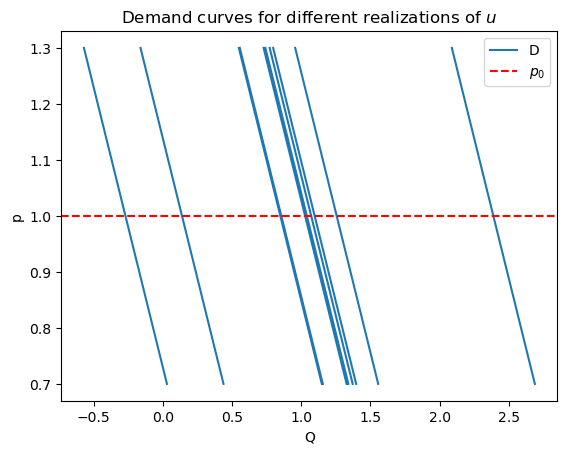

In [213]:
import matplotlib.pyplot as plt

p0 = 1

Q = pd.DataFrame({'min': α*(p0-0.3) + Udf['u'],
                  'max': α*(p0+0.3) + Udf['u'],
                  'miss':-1})

# Inverse counterfactual demand & supply (for plotting)
D = Q.add(-Udf['u'],axis=0)/α  

counterfactual=pd.DataFrame({'D':D.stack(),
                             'Q':Q.stack()})

counterfactual=counterfactual.replace(-1,np.nan)

_ = counterfactual.plot(x='Q')
plt.axhline(y = p0, color = 'r', linestyle = '--', label='$p_0$')
plt.ylabel('p')
plt.title('Demand curves for different realizations of $u$')
plt.legend()

Note that setting the price at $p = p_0$ has no effect on the distribution of $u$.

Show probability distribution function of $u$:

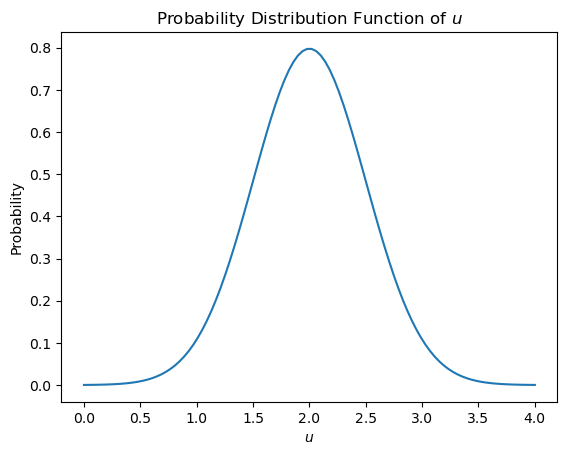

In [214]:
import numpy as np

X = np.linspace(0,4,100).tolist()

plt.plot(X, [u.pdf(z) for z in X])
plt.xlabel('$u$')
plt.ylabel('Probability')
plt.title('Probability Distribution Function of $u$')
plt.show()

Calculate expected demand:

$\mathbb{E}(q_D(p_0)) = \int_{}^{} q_D(p_0, u)dF_u(u)$

In [215]:
from scipy.integrate import quad

D_exp = quad(lambda x: (α*p0 + x)*u.pdf(x), -np.inf, np.inf)

D_exp

(1.0000000000000002, 3.5552369520475e-10)

### (2) (Condition) What is the expected demand if we observe $p = p_0$?

Note that many possible combinations of $u$ and $v$ can result in observing $p_0$.

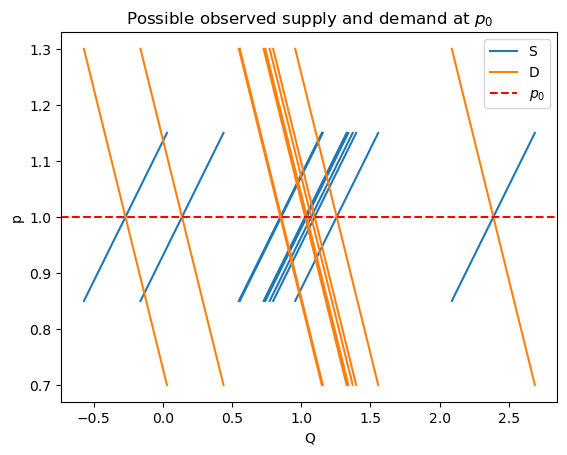

In [216]:
# Take u as given

# Find v such that p=p0 for given u
v0 = (α - β)*p0 + Udf['u']

Q = pd.DataFrame({'min': np.minimum(α*(p0-0.3) + Udf['u'], β*(p0+0.3) + v0),
                  'max': np.maximum(α*(p0+0.3) + Udf['u'], β*(p0-0.3) + v0),
                  'miss':-1})

# Inverse counterfactual demand & supply (for plotting)
D = Q.add(-Udf['u'],axis=0)/α  
S = Q.add(-v0,axis=0)/β

counterfactual=pd.DataFrame({'S':S.stack(),
                             'D':D.stack(),
                             'Q':Q.stack()})

counterfactual=counterfactual.replace(-1,np.nan)

_ = counterfactual.plot(x='Q')
plt.axhline(y = p0, color = 'r', linestyle = '--', label='$p_0$')
plt.ylabel('p')
plt.title('Possible observed supply and demand at $p_0$')
plt.legend()

Expected quantity demanded:

$\mathbb{E}[q^*(u,v) | q_D(p_0, u)=q_S(p_0, v)]$

When $q_S = q_D$, then $\alpha p + u = \beta p + v$

Let $v = u + (\alpha - \beta)p$

$f_{q^*}(u) = f_u(u) \cdot f_v(v)|\frac{\partial v}{\partial u}|$

$\mathbb{E}[q^*(u,v) | q_D(p_0, u)=q_S(p_0, v)] = \int_{}^{} q_D(p_0, u)dF_u(u)dF_v(u + (\alpha - \beta)p)$

In [217]:
# redefine q_D and v in terms of u
D_exp = quad(lambda x: (α*p0 + x)*u.pdf(x)*v.pdf(x + (α - β)*p0), -np.inf, np.inf)
D_exp

(0.6638800836636456, 1.0814326323877074e-08)

### (3) (Counterfactual) If prices and quantities are observed to be $(p_0, q_0)$, what would demand be if we were to change the price to $p_1$, ceteris paribus?

We can infer the value of $u_0$ at $(p_0, q_0)$

$$
u_0 = q_0 - \alpha p_0
$$

Then we can calculate:
$$
\Delta = q_D(p_1, u_0) - q_D(p_0, u_0)
$$

Let's use the first row of `df` as $(p_0, q_0)$ and let $p_1 = 1.1 p_0$

In [218]:
p0 = df['p'].iloc[0]
q0 = df['q'].iloc[0]

p1 = 1.1*p0

u0 = q0 - α*p0

delta = (α*p1 + u0) - (α*p0 + u0)

qd1 = q0 + delta

print(delta)

-0.0964498084554366


Text(0.5, 1.0, 'Effect of change in price on quantity demanded, ceteris paribus')

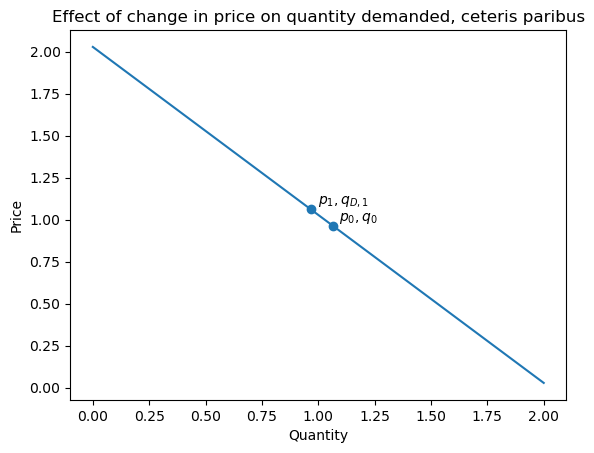

In [219]:
x = np.linspace(0, 2, 100).tolist()
y = [(q - u0)/α for q in x]
plt.plot(x, y)
plt.scatter([q0, qd1], [p0, p1])
label_offset = 0.03
plt.annotate('$p_0, q_0$', (q0+label_offset, p0+label_offset))
plt.annotate('$p_1, q_{D,1}$', (qd1+label_offset, p1+label_offset))
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Effect of change in price on quantity demanded, ceteris paribus')

## 4. Weak Instruments

This problem explores the problem of weak instruments. The basic setup should be familiar, with

$\begin{equation*}
y = \beta x + u \\
x = Z \pi + v
\label{eq:weak_instruments} \tag{3}
\end{equation*}$

Note that we’ve assumed that $x$ is a scalar random variable, and that $Z$ is an $\ell$-vector. (In general we might have $k$ endogenous $x$ variables, so long as we have $\ell > k$.)

### (1) Construct a data-generating process `dgp` which takes as arguments $(n, \beta, \pi)$ and returns a triple $(y, x, Z)$ of $n$ observations.

In [220]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# Unobservable component of instrument z
# Can have any distribution one pleases
w = iid.beta(1,2,loc=-iid.beta(1,2).mean())

In [221]:
w.rvs(15)

np.c_[10+w.rvs(15), w.rvs(15)**2]@[2,1]

array([19.44113969, 20.34084066, 20.12787876, 20.10439802, 19.44956195,
       20.54730019, 21.1329361 , 19.67604903, 19.77391356, 20.72771916,
       19.41746733, 19.46668046, 20.05843603, 20.71603868, 19.38806831])

In [222]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# Unobservable component of instrument z
# Can have any distribution one pleases
w = iid.beta(1,2,loc=-iid.beta(1,2).mean()) # Centered for convenience

# Let l = 2
Z = np.c_[10+w.rvs(15), w.rvs(15)**2]

# Structural parameters;
beta = -1
pi = 2  
sigma = {'u':1/2,'v':1/3}
mu = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=mu['u'], scale=sigma['u'])  # Demand shocks
v = iid.norm(loc=mu['v'], scale=sigma['v'])  # Supply shocks

def weak_dgp(n, beta, pi):
    """
    Generate data consistent with equations in Weak Instrument problem.

    Returns a tuple with numpy arrays y, x, and Z, all of length n
    """
    # Arrange u and v into matrix
    U = np.c_[u.rvs(n), v.rvs(n)]
    Udf = pd.DataFrame(U,columns=['u','v']) # For future reference
    
    # Relate Z to v
    # Let l = 1
    unobserved_shock = w.rvs(n)/10
    Z = (1-unobserved_shock)*np.exp(4*Udf['v'] - unobserved_shock)
    
    # Construct x
    x = Z*pi + v.rvs(n)
#     x = Z@pi + v.rvs(n) # if l > 1
    
    # Construct y
    y = beta*x + u.rvs(n)
    
    # Store in DataFrame
    df = pd.DataFrame(columns=['y', 'x', 'Z'])
    df['y'] = y
    df['x'] = x
    df['Z'] = Z # note, this works because l = 1
#     return y, x, Z
    return df[['y']], df[['x']], df[['Z']]

In [223]:
y, x, Z =  weak_dgp(10000, 1, 1)


### (2) Use the `dgp` function you’ve constructed to explore IV (2SLS) estimates of $\beta$ as a function of $\pi$ when $\ell = 1$ using a Monte Carlo approach, assuming homoskedastic errors.

#### (a) Write a function `two_sls` which takes as arguments $(y, x, Z)$ and returns two-stage least squares estimates of $\beta$ and the standard error of the estimate.

$\begin{equation*}
y = \beta x + u \\
x = Z \pi + v
\label{eq:weak_instruments} \tag{3}
\end{equation*}$

In [224]:
from scipy.linalg import inv

def two_sls(y, x, Z):
    '''Takes y, x, and Z and returns a two-stage least squares estimates of beta and its standard error'''
    # first stage, regress x on Z
    pi_hat = np.linalg.solve(Z.T@Z,Z.T@x)
    x_hat = Z@pi_hat
    
    # second stage, regress y on x-hat
    b = np.linalg.solve(x_hat.T@x_hat, x_hat.T@y)
    
    # compute standard error
    xb_df = x@b
    xb_df = xb_df.rename(columns={0:'y'})
    e = y - xb_df
    s2 = (e.T@e)/(len(y)-1)
    vb = e.var()[0]*inv(x_hat.T@x_hat)
#     vb = s2*inv(x_hat.T@x_hat) # why so different??
    seb = np.sqrt(np.diag(vb))
    
    # Store in DataFrame
    df = pd.DataFrame(columns=['b', 'seb'])
    df['b'] = b[0]
    df['seb'] = seb
    return df[['b']], df[['seb']]

b, seb = two_sls(y, x, Z)
print(b)
print(seb)

          b
0 -1.536186
        seb
0  0.029236


C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)


#### (b) Taking $\beta = \pi = 1$, use repeated draws from `dgp` to check the bias, and precision of the `two_sls` estimator, as well as the size and power of a $t$-test of the hypothesis that $\beta = 0$. Discuss. Does a 95% confidence interval (based on your 2SLS estimator) correctly cover 95% of your Monte Carlo draws?

In [225]:
def simulator(N, n, beta, pi, dgp):
    """
    Perform N draws of sample size n with parameters beta and pi.
    """
    results = pd.DataFrame(columns=['b', 'seb'])
    for i in range(N):
        y, x, Z =  dgp(n, beta, pi)
        b, seb = two_sls(y, x, Z)
        results0 = pd.concat([b, seb], axis=1)
        results = pd.concat([results, results0], axis=0)

    return results

N = 1000
results = simulator(N, 10000, 1, 1, weak_dgp)

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\3187378265.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, results0], axis=0)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_hat.T@x_hat)
C:\Users\elean\AppData\Local\Temp\ipykernel_14180\4048878482.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vb = e.var()[0]*inv(x_ha

Text(0.5, 1.0, 'Histogram of b for 1000 random draws')

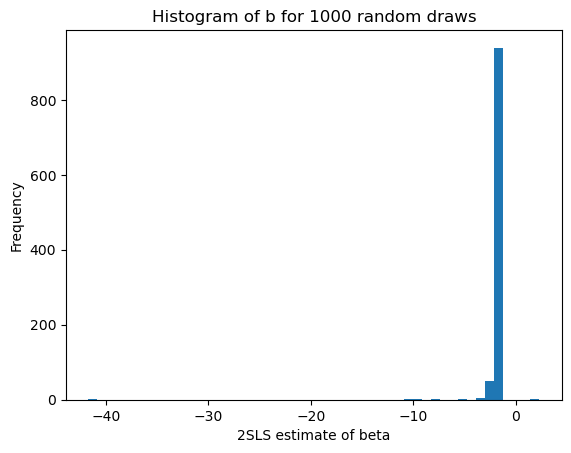

In [226]:
plt.hist(results['b'], bins=50)
plt.xlabel('2SLS estimate of beta')
plt.ylabel('Frequency')
plt.title('Histogram of b for {} random draws'.format(N))

Text(0.5, 1.0, 'Histogram of seb for 1000 random draws')

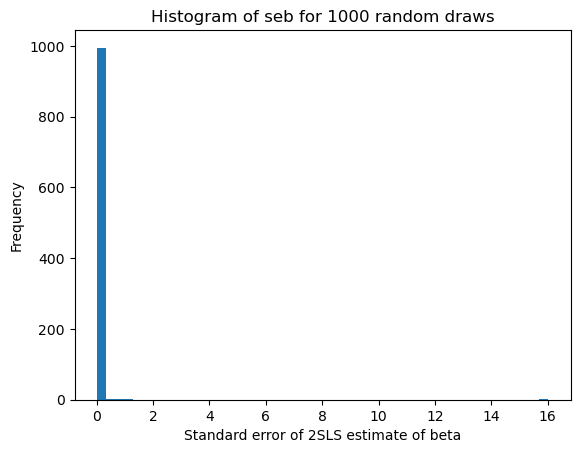

In [227]:
plt.hist(results['seb'], bins=50)
plt.xlabel('Standard error of 2SLS estimate of beta')
plt.ylabel('Frequency')
plt.title('Histogram of seb for {} random draws'.format(N))

In [228]:
# TODO: Check bias, precision, size and power of 2SLS estimator
# TODO: Check size and power of t-test
# TODO: Does a 95% confidence interval (based on your 2SLS estimator) correctly cover 95% of your Monte Carlo draws?

#### (c) Taking $\beta = 1$, but allowing $\pi \in [0, 1]$ again evaluate the bias and precision of the estimator, and the size and power of a $t$-test. The $Z$ instrument is "weak" when $\pi$ is "close" to zero. Comment on how a weak instrument affects two-stage least squares estimators.

### (3) Now consider another "weak" instruments problem. Consider the sequence $\{1, 1/2, 1/4, 1/8, . . . \}$. Let $\ell = 1, 2, 3, . . .$, and for a particular value of $\ell$ let the vector of parameters $\pi_\ell$ consist of the first $\ell$ elements of the sequence. Thus, your `dgp` should now return $Z$ we can treat as an $n \times \ell$ matrix, with successive columns of $Z$ increasingly "weak" instruments.

#### (a) Taking $\beta = 1$, but allow $\ell$ to increase $(\ell = 1, 2, ...)$. Note that for $\ell > 1$ this is now an "overidentified" estimator. Describe the bias and precision of the estimator, and the size and power of a $t$-test. Compare with the case of $\ell = 1$ and $\pi = 1$.

#### (b) What can you say about the optimal number of instruments (choice of $\ell$) in this case?